# Portfolio Management Final Exam

Quanzhi Bi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
from tqdm import tqdm
import os
from collections import defaultdict
import time

## Problem 3.1

See implementation of (a)-(d) in the class `FactorReturnEstimator`

In [2]:
class FactorReturnEstimator:
    '''
    Fractor Return Estimator solving Problem 3.1 (a) - (d)

    Parameters
    --------------------

    input_dir: str
        the directory of the raw datasets containing compressed
        pickle files

    cache_dir: str
        the directory of the cached files. In this program we 
        will save each date's factors as a csv file on the disk
        to avoid filling out the memory.

    disable_progress: bool, default=False
        disable the progress bar. The whole process would take
        several minutes for a single alpha factor.

    '''

    def __init__(self, input_dir, cache_dir, disable_progress=False):
        '''
        ctor
        '''
        self.disable = disable_progress
        cache_dir = cache_dir.rstrip('/')
        input_dir = input_dir.rstrip('/')

        if os.path.isdir(cache_dir) == False:
            # cache the data so that each date have a csv file
            # stored in the disk, so that we don't need to feed
            # all the data into the memory
            os.makedirs(cache_dir)
            self.dates = []
            for year in range(2003, 2011):
                fil = input_dir + "/pandas-frames." + str(year) + ".pickle.bz2"
                # unzip the compressed pickle files
                frames = pickle.load(bz2.open(fil, "rb"))
                # a tqdm progress bar iterator
                loop = tqdm(frames.items(), leave=False, disable=self.disable)
                for date, df_date in loop:
                    self.dates.append(date)
                    filepath = cache_dir+'/'+date+'.csv'
                    if os.path.isfile(filepath) == False:
                        df_date.to_csv(filepath)
                    loop.set_description('extracting year={:d}'.format(year))
        else:
            # directly read the dates from the disk file names
            self.dates = [filename.replace('.csv', '') for filename
                          in os.listdir(cache_dir) if filename[-4:] == '.csv']

        self.cache_dir = cache_dir
        self.dates = sorted(self.dates)

    def wins(self, x, a, b):
        '''
        Winsorize the array to [a, b] to dampen the effect of outliers
        '''
        return (np.where(x <= a, a, np.where(x >= b, b, x)))

    def sharpe(self, x):
        '''
        compute the sharpe ratio of the array of daily returns

                        annualized return
        Sharpe Ratio =  ----------------------
                        annualized volatility
        '''
        # assume a year consists of 252 trading days
        annualized_ret = np.prod(x+1)**(252/len(x))-1
        annualized_vol = x.std() * np.sqrt(252)
        return annualized_ret / annualized_vol

    def estimate_factor_returns(self, alpha_name, risk_names, plot=True, ax=None, **plot_kwargs):
        '''
        estimatr the factor returns

        Parameters
        -----------------
        alpha_name: str
            the name of your potential alpha factor

        risk_names: list of str
            the names of the canonical risk factors

        plot: bool, default=True
            if True, plot the cumulative sum of the coefficients of the factor

        ax: matplotlib.axes._subplots.AxesSubplot
            the axes of matplotlib to plot on if provided

        plot_kwargs: dict, default={}
            the keyword arguments of the ax.plot()

        Return
        -----------------
        df: pd.Dataframe
            the daily coefficients of the factor (daily factor returns)

        sharpe_ratio: flaot
            the sharpe ratio of the factor return
        '''
        ret = []
        # a tqdm progress bar iterator
        loop = tqdm(self.dates, disable=self.disable, leave=False)
        for date in loop:
            # first read the daily factors from the disk
            filename = self.cache_dir+'/'+date+'.csv'
            df = pd.read_csv(filename)
            # only use rows with IssuerMarketCap > 1 billion dollars
            estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
            estu = estu[['Ret', alpha_name]+risk_names]
            # clean out the NaN values
            estu.dropna(inplace=True)

            # Problem 3.1(a)
            # build a matrix X containing the single alpha factor
            # and the canonical risk factors
            X = estu[[alpha_name]+risk_names]

            # Problem 3.1(b)
            # winsorize the returns to [-0.25, 0.25]
            # to dampen the effect of outliers
            y = self.wins(estu['Ret'], -0.25, 0.25)

            # Problem 3.1(c)
            # estimate the model y = Xf + e using multivariate OLS
            model = sm.OLS(y, sm.add_constant(X))
            results = model.fit()

            # Problem 3.1(d)
            # get the coefficient of the alpha factor
            ret.append(results.params[alpha_name])
            loop.set_description('estimating {:s}'.format(alpha_name))

        # and stuff the alpha coef in a time series associated to the given date
        df = pd.DataFrame({'Date': self.dates, alpha_name: ret})
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # compute the sharpe ratio
        sharpe_ratio = self.sharpe(df[alpha_name])

        if plot == True:
            # if the axes of plot is not provided
            # we create one inside this method
            if ax is None:
                fig, ax = plt.subplots(figsize=(12, 4))
            # plot the cumulative sum of the coefficients
            ax.plot(df[alpha_name].cumsum(), **plot_kwargs)
            ax.set_title('{:s}, Sharpe Ratio {:.2f}'.format(
                alpha_name, sharpe_ratio))
            ax.set_xlabel('Date')
            ax.set_ylabel('cum ret')

        return df, sharpe_ratio

Running one OLS per day over several years, Plot the cumulative sum of the coefficients and calculate the sharpe ratio (in the title of the plot). 

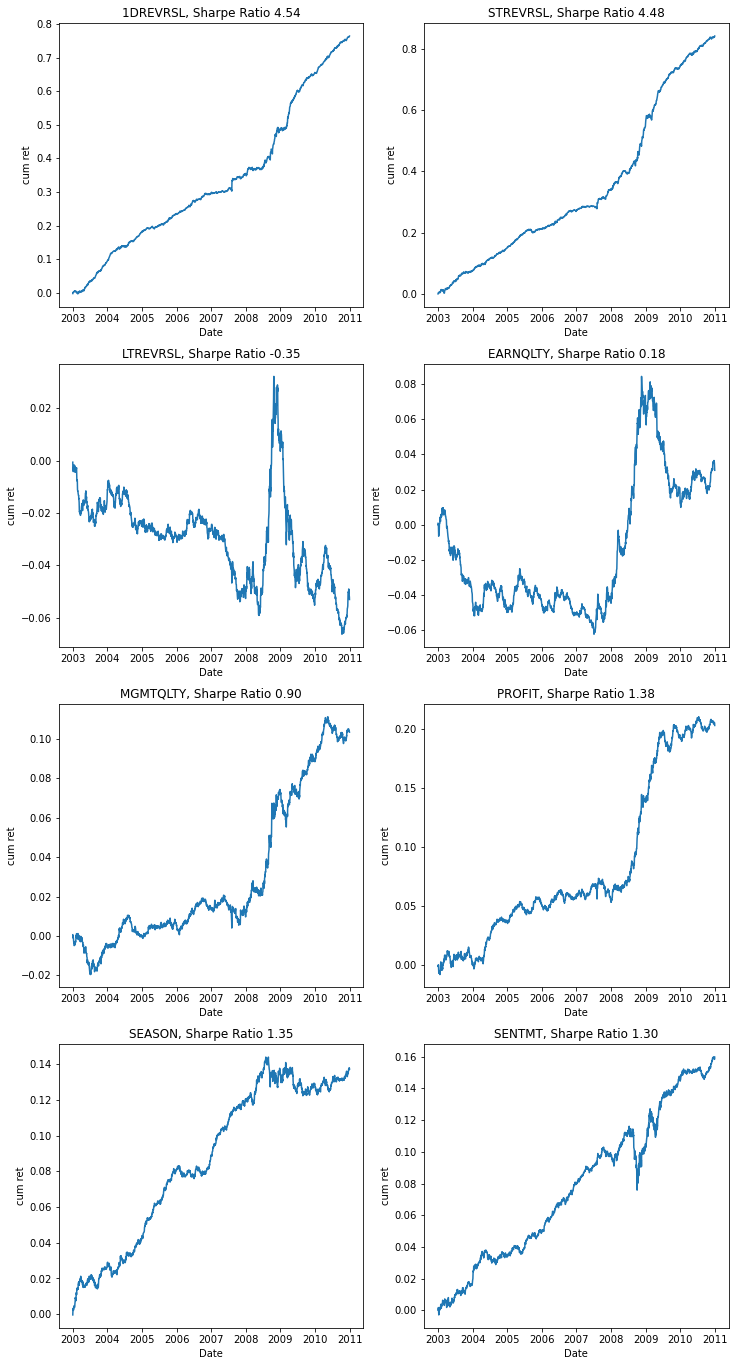

In [3]:
alphas = ['1DREVRSL', 'STREVRSL', 'LTREVRSL', 'EARNQLTY',
          'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

industry_factors = [
    'AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
    'BANKS', 'BEVTOB', 'BIOLIFE', 'BLDGPROD', 'CHEM',
    'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
    'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB', 'DIVFIN',
    'DIVYILD', 'DWNRISK', 'ELECEQP', 'ELECUTIL', 'FOODPROD',
    'FOODRET', 'GASUTIL', 'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG',
    'HOUSEDUR', 'INDMACH', 'INSURNCE', 'INTERNET', 'LEISPROD',
    'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH', 'MULTUTIL',
    'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER',
    'PHARMA', 'PRECMTLS', 'PSNLPROD', 'REALEST', 'RESTAUR',
    'ROADRAIL', 'SEMICOND', 'SEMIEQP', 'SOFTWARE', 'SPLTYRET',
    'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT',
    'WIRELESS'
]

style_factors = ['BETA', 'SIZE', 'MOMENTUM', 'VALUE']

df_ret = {}


estimator = FactorReturnEstimator(input_dir='APANPS5440', cache_dir='frames')

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 4*6))

for alpha_name, ax in zip(alphas, axes.flat):

    df, SR = estimator.estimate_factor_returns(
        alpha_name=alpha_name,
        risk_names=industry_factors + style_factors,
        plot=True, ax=ax)
    df_ret[alpha_name] = df

In [4]:
df_ret = pickle.load(open('pandas-frames.alphas.pickle', 'rb'))

Comment on whether this time series is achievable as the returns on an investment strategy, both with and without trading-costs.

If we trade without trading-costs, then `1DREVRSL`, `STREVRSL`, and `PROFIT` are achievable since they have a good Shapre ratio and a low maximized drawback. The other factors are either low Sharpe ratio or have a large drawback during the backtest period.

If we further consider the trading-cost, `1DREVRSL` and `STREVRSL` coule be problematic since the factors move so fast, which will bring us huge T-cost.

In [5]:
pickle.dump(df_ret, open('pandas-frames.alphas.pickle', 'wb'))
from functools import reduce
dfs = [df for key, df in df_ret.items()]
df_alpha = reduce(lambda left, right: left.join(right), dfs)
df_alpha[int(2015*2/3):].index

DatetimeIndex(['2008-05-05', '2008-05-06', '2008-05-07', '2008-05-08',
               '2008-05-09', '2008-05-12', '2008-05-13', '2008-05-14',
               '2008-05-15', '2008-05-16',
               ...
               '2010-12-17', '2010-12-20', '2010-12-21', '2010-12-22',
               '2010-12-23', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', name='Date', length=672, freq=None)

## Problem 3.2

See the implementation of (a)-(c) in `CostlessPortfolioOptimizer`

In [24]:
class CostlessPortfolioOptimizer:

    '''
    Costless Portfolio Optimization solving Problem 3.2 (a) - (f)

    Parameters
    ---------------
    cov_dir: str
        the directory of the compressed pickle files storing covariance

    cache_frames_dir, str
        the directory of the cached frames csv files

    cache_dir, str
        the directory of the cached covariance csv files

    df_alpha: dict or pd.Dataframe
        the alpha factor returns

    canonical_risk_factors, list of str
        the cannonical risk factors

    disable_progress, bool, default=False
        to disable the progressbar

    '''

    def __init__(self, cov_dir, cache_frames_dir, cache_dir, df_alpha, 
                 canonical_risk_factors, disable_progress=False):
        self.cov_dir = cov_dir.rstrip('/')
        self.cache_frames_dir = cache_frames_dir.rstrip('/')
        self.cache_dir = cache_dir.rstrip('/')
        self.df_alpha = df_alpha
        self.alpha_names = list(df_alpha)
        # Problem 3.2(a)
        # calculate its mean factor return over the
        # first 2/3 of the date range (the “in-sample period”)
        # and store these coefficients in a vector
        self.alpha = df_alpha[:int(len(df_alpha)*2/3)].mean().values
        self.canonical_risk_factors = canonical_risk_factors
        self.p = len(canonical_risk_factors)
        self.disable = disable_progress
        # create a lookup table of the factor names
        # to make the code run faster
        self.lookup_table = defaultdict(
            lambda: -1,
            zip(canonical_risk_factors, range(self.p))
        )

        if os.path.isdir(self.cache_dir) == False:
            # cache the data so that each date have a csv file
            # stored in the disk, so that we don't need to feed
            # all the data into the memory
            os.makedirs(self.cache_dir)
            self.dates = []
            for year in range(2003, 2011):
                fil = self.cov_dir + "/covariance." + str(year) + ".pickle.bz2"
                # unzip the compressed pickle files
                cov_dict = pickle.load(bz2.open(fil, "rb"))
                # a tqdm progress bar iterator
                loop = tqdm(cov_dict.items(), leave=False,
                            disable=self.disable)
                for date, df_date in loop:
                    self.dates.append(date)
                    filepath = self.cache_dir+'/'+date+'.csv'
                    if os.path.isfile(filepath) == False:
                        df_date.to_csv(filepath)
                    loop.set_description('extracting year={:d}'.format(year))
        else:
            # directly read the dates from the disk file names
            self.dates = [filename.replace('.csv', '') for filename
                          in os.listdir(self.cache_dir) if filename[-4:] == '.csv']

        # only calculate over the last 1/3 of the dates (the “out of sample period”).
        self.dates = sorted(self.dates)[int(len(df_alpha)*2/3):]

    def get_F(self, df_cov):
        '''
        Subsets the covariance matrix dataframe to the canonical risk factors. 
        Hence you will be able to calculate F on any given date.

        Parameters
        ------------------
        df_cov, pd.Dataframe
            the dataframe of the factors on a given date
        '''

        F = np.zeros((self.p, self.p))

        for i in range(len(df_cov)):
            factor1 = df_cov['Factor1'].iloc[i]
            factor2 = df_cov['Factor2'].iloc[i]

            idx1 = self.lookup_table[factor1]
            idx2 = self.lookup_table[factor2]
            if idx1 == -1 or idx2 == -1:
                continue
            varcovar = df_cov['VarCovar'].iloc[i]
            F[idx1][idx2] = varcovar
            if idx1 != idx2:
                F[idx2][idx1] = varcovar
        
        # assume the covariance matrix is annualized percentage squared
        # so we need to divid by (100*sqrt(252)) ** 2
        return F/10000/252

    def f(self, h):
        '''
        f = 0.5k hT QT Q h + 0.5k hT D h - alphaT h
        '''
        tmp = 0.0
        tmp += 0.5 * self.kappa * np.sum(np.matmul(self.Q, h) ** 2)
        tmp += 0.5 * self.kappa * np.dot(h ** 2, self.specVar)
        tmp -= np.dot(h, self.alpha_vec)

        return(tmp)

    def grad(self, h):
        '''
        grad = k QTQ h + kDh - alpha,

        we don't compute QTQ since it's an nxn matrix

        we compute QT @ ( Q @ h)
        '''
        tmp = - self.alpha_vec
        Qh = np.matmul(self.Q, h)
        tmp += self.kappa * np.matmul(self.QT, Qh)
        tmp += self.kappa * (self.specVar * h)

        return tmp

    def optimize(self, kappa):
        '''
        For each date in the out-of-sample period, 
        find h∗ that minimizes the objective
        '''

        self.kappa = kappa
        profits = []
        profits_exact = []
        positions = []
        vols = []
        ido_frac = []
        industry_frac = []
        style_frac = []
        # for each date in the out-sample period
        loop = tqdm(self.dates, disable=self.disable, leave=False)
        for date in loop:
            # Problem 3.2(b)
            # calculate F on that  date
            df_cov = pd.read_csv(self.cache_dir+'/'+date+'.csv')
            F = self.get_F(df_cov)
            # get X and specVar
            df_frames = pd.read_csv(self.cache_frames_dir+'/'+date+'.csv')
            df_frames = df_frames.loc[df_frames.IssuerMarketCap > 1e9].copy(
                deep=True)
            X = df_frames[self.canonical_risk_factors].values
            # compute Q using a simple matrix factorization
            XT = X.transpose()
            self.Q = np.matmul(scipy.linalg.sqrtm(F), XT)
            self.QT = self.Q.transpose()

            # notice that the SpecRisk column is annulized percent volatility
            annualized_vol = df_frames['SpecRisk'].values / 100
            # convert annulaized vol to daily variance
            # assume 1 year = 252 trading days
            # again we need to divid by (100*sqrt(252)) ** 2
            self.specVar = annualized_vol ** 2 / 252

            # get combined alpha
            X_alpha = df_frames[self.alpha_names].values
            self.alpha_vec = np.matmul(X_alpha, self.alpha)

            # initailize h to be equal weighted portfolio
            h0 = np.zeros(len(df_frames))

            # Problem 3.2(c)
            # get the optimized result
            optimizer_result = scipy.optimize.fmin_l_bfgs_b(
                self.f, h0, self.grad)
            h_star = optimizer_result[0]
            positions.append(h_star)
            # solve the optimization in a closed form
            A = kappa * (np.matmul(self.Q.transpose(), self.Q) +
                         np.diag(self.specVar))
            B = np.dot(self.alpha, X_alpha.transpose())

            h_star_exact = np.linalg.solve(A, B)
            R = df_frames['Ret'].values

            # Problem 3.2(d)
            # For every day in the out of sample period, compute the pre-t-cost profit
            profits.append(np.dot(h_star, R))
            profits_exact.append(np.dot(h_star_exact, R))

            # Problem 3.2(e)
            var_ido = np.dot(h_star ** 2, self.specVar)

            x = np.matmul(XT, h_star)
            Fx = np.matmul(F, x)
            var_factor = x * Fx

            # the last four factors are style
            var_style = np.sum(var_factor[-4:])
            # the rest of them are industry
            var_industry = np.sum(var_factor[:-4])

            var_total = (var_ido+var_industry+var_style)
            vol = np.sqrt(var_total)

            vols.append(vol)
            ido_frac.append(var_ido/var_total)
            industry_frac.append(var_industry/var_total)
            style_frac.append(var_style/var_total)

            loop.set_postfix(warnflag=optimizer_result[2]['warnflag'])

        # and stuff the profits in a time series associated to the given date
        df = pd.DataFrame({'Date': self.dates,
                           'profit': profits,
                           'exact': profits_exact,
                           'vols': vols,
                           'ido_frac': ido_frac,
                           'industry_frac': industry_frac,
                           'style_frac': style_frac})
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        return df, positions


canonical_risk_factors = industry_factors + style_factors


optimizer = CostlessPortfolioOptimizer(cov_dir='APANPS5440/',
                                       cache_dir='covariances/',
                                       cache_frames_dir='frames/',
                                       df_alpha=df_alpha,
                                       disable_progress=False,
                                       canonical_risk_factors=canonical_risk_factors)
df, hs = optimizer.optimize(kappa=1e-6)

For every day in the out of sample period, compute the pre-t-cost profit and print out the sharpe ratio.

Text(0.5, 1.0, 'Sharpe ratio = 4.871')

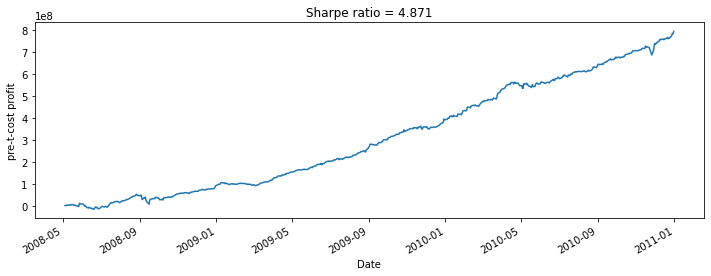

In [25]:
# Problem 3.2(d)
# Plot the cumulative sum, and print out the sharpe ratio of the out-of-sample
fig, ax = plt.subplots(figsize=(12, 4))
df['profit'].cumsum().plot(ax=ax)
ax.set_ylabel('pre-t-cost profit')
mean = df['profit'].mean() * 252
std = df['profit'].std() * np.sqrt(252)
ax.set_title('Sharpe ratio = {:.3f}'.format(mean/std))

For every day in the out of sample period, do a variance decomposition on $h^*$

Text(0.5, 1.0, 'Total Volatility')

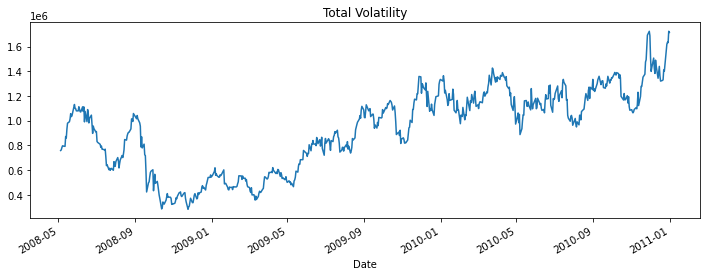

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
df['vols'].plot(ax=ax)
ax.set_title('Total Volatility')

Text(0.5, 1.0, 'Fraction of Idiosyncratic Variance')

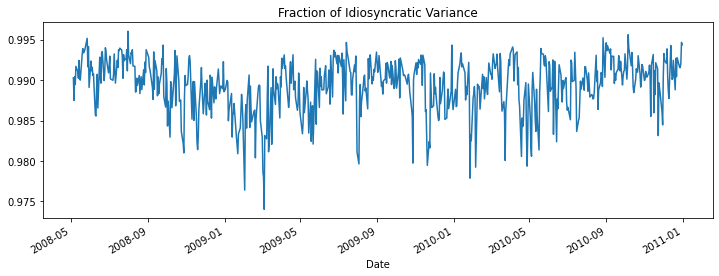

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
df['ido_frac'].plot(ax=ax)
ax.set_title('Fraction of Idiosyncratic Variance')

Text(0.5, 1.0, 'Fraction of Industry Variance')

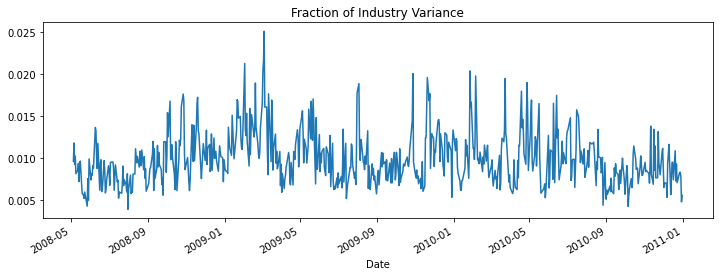

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
df['industry_frac'].plot(ax=ax)
ax.set_title('Fraction of Industry Variance')

Text(0.5, 1.0, 'Fraction of Style Variance')

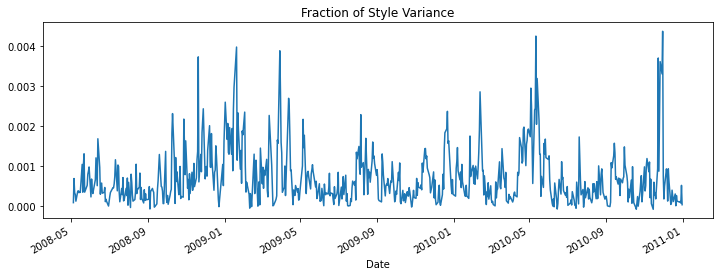

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
df['style_frac'].plot(ax=ax)
ax.set_title('Fraction of Style Variance')

Plot the long, short, net and gross market values, in dollars, for every optimal portfolio in the out of sample period.

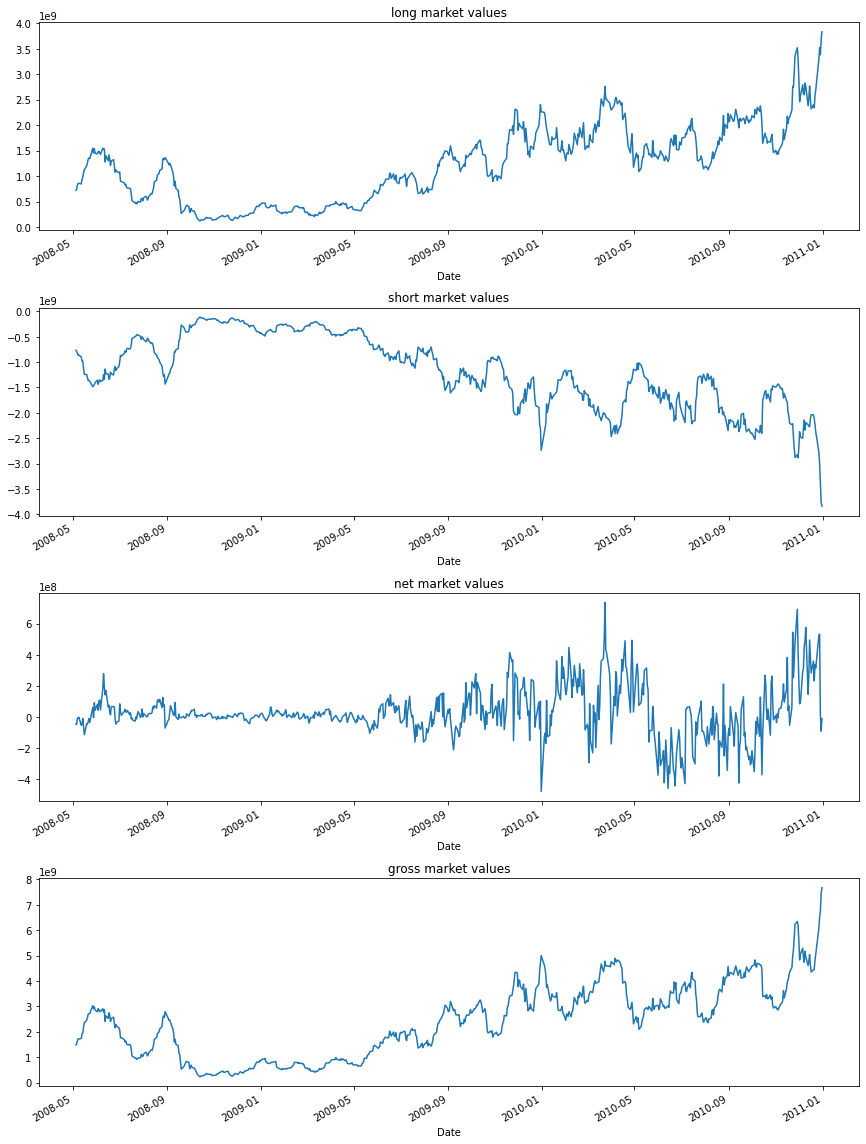

In [30]:
# Problem (f)
long = []
short = []
net = []
gross = []
for h in hs:
    long.append(np.sum(h[h > 0]))
    short.append(np.sum(h[h < 0]))
    net.append(np.sum(h))
    gross.append(np.sum(np.abs(h)))

df_mkt_values = pd.DataFrame({'Date': df.index,
                              'long': long,
                              'short': short,
                              'net': net,
                              'gross': gross
                              }).set_index('Date')

fig, ax = plt.subplots(4,1,figsize=(12, 16))
df_mkt_values['long'].plot(ax=ax[0])
df_mkt_values['short'].plot(ax=ax[1])
df_mkt_values['net'].plot(ax=ax[2])
df_mkt_values['gross'].plot(ax=ax[3])
ax[0].set_title('long market values')
ax[1].set_title('short market values')
ax[2].set_title('net market values')
ax[3].set_title('gross market values')
plt.tight_layout()

## Problem 3.3

The formula would be

$$
h^* = \left(\kappa Q^TQ+\kappa D\right)^{-1}\alpha
$$

In `CostlessPortfolioOptimizer` class we implemented this formula by using `np.linage.solve` to avoid inverting a huge matrix.

As we can see it's very close to the numerical optimized result.

Text(0, 0.5, 'pre-t-cost profit')

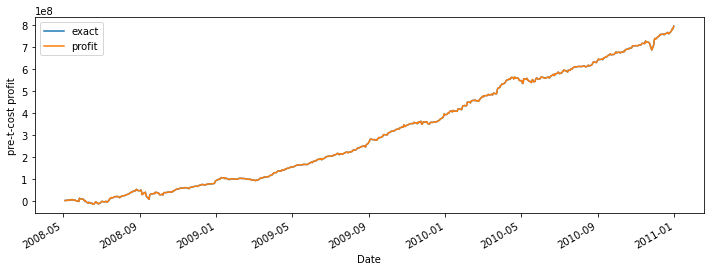

In [32]:
# Problem 3.3
# Plot the cumulative sum,
fig, ax = plt.subplots(figsize=(12, 4))
df[['exact', 'profit']].cumsum().plot(ax=ax)
ax.set_ylabel('pre-t-cost profit')